In [1]:
# Base libraries
from collections import namedtuple, deque
from dataclasses import dataclass
from typing import List, Tuple, Dict, Callable, Any
import numpy as np
import pandas as pd
import random
import pickle
import os
from tqdm import tqdm

# ML libraries
import torch

# Local imports
from env import Env
from agents.random_agent import RandomAgent
from agents.deep_q_agent import DeepQAgent
from agents.cql_agent import CQLAgent
from agents.minimax_agent import MinimaxAgent
import utils
import transformer_utils

# Fix random seed
utils.seed_everything()

# Import Transformers
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

In [2]:
'''2 Options: 
        Generate Trajectories now
        Load existing Trajectories from a file
'''
GENERATE_TRAJECTORIES =  True #Set if you want to load from file or generate them here

# NOTE: Filename style: {agent_name}{input_params}_vs_{opponent_name}{input_params}_num{NUM_TRAJ}.pkl
file_to_store_to = '100k_random_traces.pkl' #Define file to where we should store the generated trajectories
file_to_load_from = '100k_random_traces.pkl'

AGENT = 1
OPPONENT = 2
# Number of created trajectories
#NUM_TRAJ = 100_000
NUM_TRAJ = 100

  0%|          | 0/100 [00:00<?, ?it/s]

Episode: 0, RTG (start) : -0.45000000000000007, length: 12, reward end: -1, done: True
Score: Agent 0 - 1 Opponent


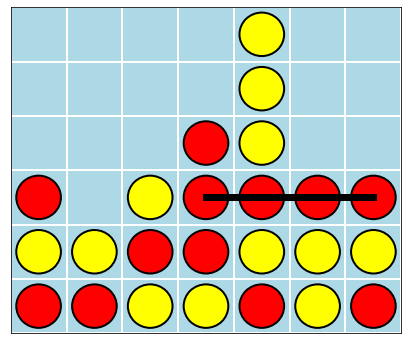

100%|██████████| 100/100 [00:00<00:00, 273.81it/s]

Score: Agent 46 - 54 Opponent. There were 0 Ties


In [3]:


if GENERATE_TRAJECTORIES:
    # Generate T_offline (offline Trajectories for the offline initialization of the replay buffer)
    # NOTE: Corresponding paper: https://arxiv.org/pdf/2202.05607.pdf

    offline_trajectories = []

    #Initialize Environment and Agent
    env = Env()
    # agent = MinimaxAgent(env, depth=2, epsilon=0.2, player=1)
    # opponent = MinimaxAgent(env, depth=2, epsilon=0.2, player=2)
    agent = MinimaxAgent(env, depth=2, epsilon=1.0, player=1)
    opponent = MinimaxAgent(env, depth=2, epsilon=1.0, player=2)

    agent_won = 0
    agent_lost = 0

    for i in tqdm(range(0, NUM_TRAJ)):

        # Initialize other variables
        finished = -1

        #Initialize fields for trajectory
        states = []
        actions = []
        rewards = []
        dones = []

        # Make it random who gets to start the game
        # Set to true during the episode
        agent_start = random.choice([True, False])
        # Run one episode of the game
        while finished == -1:
            # Agent makes a turn
            if agent_start:
                state = env.get_state()
                #action = agent.act(state)
                action = agent.act(env.field)
                valid, reward, finished = agent.env.step(action, AGENT)
                #env.render_pretty()
                
                
                # Update current Trajectory
                #Flatten the state to be a 42-entry 1 dimensional array
                states.append(np.ravel(state))
                actions.append(action)
                rewards.append(reward)

                if finished != -1:
                    break

            else:
                agent_start = True

            # Opponent makes their turn
            #action = opponent.act(env.get_state_inverted())
            action = opponent.act(env.field)
            valid, _, finished = opponent.env.step(action, OPPONENT)

            if finished != -1: 
                # Punish Agent for losing
                if finished == OPPONENT:
                    rewards[-1] = -1
                break

        # The Flag if the Episode is finished is False for n-1 steps and True for the last step obviously..
        dones = ([False] * (len(rewards)-1)) + [True]
    
        assert len(states) == len(actions)
        assert len(actions) == len(rewards)
        assert len(dones) == len(rewards)
        length = len(states)
        RTGs = transformer_utils.calculate_RTG(rewards)
        traj = [length, states, actions, rewards, RTGs, dones]
        offline_trajectories.append(traj)

        #Keep track of statistics
        if finished == 1:
            agent_won+=1
        elif finished == 2:
            agent_lost+=1

        if i % NUM_TRAJ/3 == 0:
            print(f"Episode: {i}, RTG (start) : {RTGs[0]}, length: {length}, reward end: {rewards[-1]}, done: {dones[-1]}")
            print(f"Score: Agent {agent_won} - {agent_lost} Opponent")
            env.render_pretty()

        env.reset()
        
    # Final score
    print(f"Score: Agent {agent_won} - {agent_lost} Opponent. There were {NUM_TRAJ - agent_won - agent_lost} Ties")

    # Sort offline buffer such that the order is descending in RTGs
    # [4][0] is the first RTG of the trajectory
    sorted_offline_trajectories = sorted(offline_trajectories, key=lambda x: x[4][0], reverse = True)


    #TODO: We currently only use one side of the table for generating trajectories, we could generate twice as many by also storing the trajectories from the "enemys POV"

if GENERATE_TRAJECTORIES:
    # HERE WE STORE TRAJECTORIES THAT WE PRODUCED ABOVE, OR ALREADY PRODUCED EARLIER!

    #Safety mechanism, to show if this specific file we want to write to doesn't already exist, and we lose our data.
    #NOTE: just comment this check out if you want to overwrite a file..
    if os.path.exists('trajectories/' + file_to_store_to):
        raise FileExistsError(f"File {file_to_store_to} already exists!")
    
    #Create Trajectories folder if in-existent
    if not os.path.exists('trajectories'):
        os.makedirs('trajectories')
    # Store data within specified file
    with open("trajectories/" + file_to_store_to, 'wb') as f:
        pickle.dump(sorted_offline_trajectories, f)

else:
    #Check if the given file exists
    if not os.path.exists('trajectories/' + file_to_load_from):
        raise FileExistsError(f"File {file_to_load_from} doesn't exist!")
    
    #Load Trajectories from specified file:
    with open('trajectories/' + file_to_load_from, 'rb') as f:
        sorted_offline_trajectories = pickle.load(f)


In [4]:
# convert the actions inside the "sorted_offline_trajectories" from integer to one-hot encoded array!

for i in range(len(sorted_offline_trajectories)):
    traj = sorted_offline_trajectories[i]
    actions = traj[2]
    new_actions = []
    for a in actions:
        new_action = [0,0,0,0,0,0,0]
        new_action[a] = 1
        new_actions.append(new_action)
    sorted_offline_trajectories[i][2] = new_actions

In [5]:
# We have a dataset containing all the offline collected data
# Using this tutorial: https://huggingface.co/blog/train-decision-transformers
# We convert the dataset into data ready for the decision transformer
#Experiment with taking only the "better" fraction of the trajectories, could lead to better results
FRACTION = 0.7
N = int(FRACTION * NUM_TRAJ)
dataset = sorted_offline_trajectories[:N]
lengths = [x[0] for x in dataset]
max_episode_length = max(lengths)
print(f"Maximum Episode length: {max_episode_length}")
print(len(dataset))

# Constants represent the position of the value within a trajectory-array
# trajectory structure in the dataset: traj = [length, states, actions, rewards, RTGs, dones]
LENGTH = 0
STATES = 1
ACTIONS = 2
REWARDS = 3
RTGs = 4
DONES = 5

class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 21 #subsets of the episode we use for training
    state_dim: int = 42  # size of state space
    act_dim: int = 7  # size of action space
    max_ep_len: int = 42 # max episode length in the dataset TODO: is this the correct value?
    #scale: float = 1000.0  # normalization of rewards/returns
    n_traj: int = N # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = 7
        self.state_dim = 42
        self.dataset = dataset
        self.n_traj = len(dataset)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(np.arange(self.n_traj), size=batch_size, replace=True)
        
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # Select trajectory at given index
            feature = self.dataset[int(ind)]
            #set si randomly to start somewhere in the sequence (but at least max_len steps before the end..)
            length = self.dataset[ind][LENGTH]
            if length <= self.max_len:
                si = 0
            else:
                # we should just start from the end then, because we have sparse rewards...
                #si = random.randint(0, length - self.max_len)
                #NOTE: this case should never occur anyway if we work with a window size of the maximum possible episode length..
                si = max(0, length - self.max_len - 1)

            # get sequences from dataset
            s.append(np.array(feature[STATES][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature[ACTIONS][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature[REWARDS][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature[DONES][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature[REWARDS][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1)
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        # Converting
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        # This is how the trajectories are returned for the transformer to learn with them
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

Maximum Episode length: 20
70


In [6]:
#Training Arguments
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=30, # 120
    per_device_train_batch_size=64, # 64
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

# Initialize and then train the model
collator = DecisionTransformerGymDataCollator(dataset)
config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = transformer_utils.TrainableDT(config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
)

#NOTE: Uncomment for training
#trainer.train()

In [7]:
# store the model trained above...
# trainer.save_model("dt_model/final_minimax_offline")

# Path to your saved model
model_path = 'dt_model/final_random_offline'

# Load the model
model = transformer_utils.TrainableDT.from_pretrained(model_path)

In [ ]:
# perform online learning.
ROUNDS = 2000
#Top N trajectories
N = 500
replay_buffer = sorted_offline_trajectories[:N]
print(len(replay_buffer))
model = model.to("cpu")
max_ep_len = max_episode_length
print(f"Maximum Episode Length is {max_ep_len}")
device = "cpu"

import logging
logging.getLogger("transformers.trainer").setLevel(logging.ERROR)


training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=1, # 120
    per_device_train_batch_size=64, # 64
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
    disable_tqdm=True
)

TARGET_RETURN = 2
env = Env()

opponent = opponent = MinimaxAgent(env, depth=2, epsilon=0.0, player=2)

oldest_traj = 0
EXPLORATORY_MAX = 0.5
EXPLORATORY_MIN = 0.1

# Learn Online on traces where we always create 3 new ones and delete the worst ones from the buffer
for round in tqdm(range(1, ROUNDS)):
    replay_buffer = sorted(replay_buffer, key=lambda x: x[4][0], reverse = True)
    print(f"Round: {round}")
    exploratory = EXPLORATORY_MIN + (EXPLORATORY_MAX - EXPLORATORY_MIN) * (ROUNDS - float(round)) / ROUNDS
    print(exploratory)
    #perform a trajectory
    random.seed(round)
    traj1 = transformer_utils.create_trajectory(model, TARGET_RETURN, env, opponent, False, exploratory)
    traj2 = transformer_utils.create_trajectory(model, TARGET_RETURN, env, opponent, False, exploratory)
    traj3 = transformer_utils.create_trajectory(model, TARGET_RETURN, env, opponent, False, exploratory)
    #remove oldest trajectory
    #replay_buffer[oldest_traj] = traj1
    #replay_buffer[(oldest_traj + 1) % N] = traj2
    #replay_buffer[(oldest_traj+ 2) % N] = traj3
    #oldest_traj = (oldest_traj + 3) % N
    replay_buffer[-1] = traj1
    replay_buffer[-2] = traj2
    replay_buffer[-3] = traj3


    #learn on the new ones..
    model = transformer_utils.train_model(model, training_args, replay_buffer, collator)
    model = model.to("cpu")
    print()

#NOTE: uncomment if you want to store the model
#trainer.save_model("dt_model/final_random_online")
    


In [ ]:
from agents.cql_agent import CQLAgent
from agents.deep_q_agent_double_q import DDQAgent

In [ ]:
# Path to your saved model
model_path = 'dt_model/final_minimax_online'

# Load the model
model = transformer_utils.TrainableDT.from_pretrained(model_path)

In [ ]:
# Evaluate Agent against a specified opponent
utils.seed_everything(41)
env = Env()
# opponent = MinimaxAgent(env, depth=2, epsilon=0.3, player=2)
opponent = RandomAgent(env)
# opponent = CQLAgent(env, network_type='FCNN', epsilon_max=0.1)
# opponent.load_model('./saved_models/CQLAgent_FCNN_RS41.pt')

transformer_utils.evaluate_model(model, opponent, 1000, 2, False, agent_start=False)